In [1]:
try:
    import jax
    import jax.numpy as jnp
except:
    ModuleNotFoundError
    %pip install jax jaxlib
    import jax
    import jax.numpy as jnp

try:
    from tensorflow_probability.substrates import jax as tfp
except:
    ModuleNotFoundError
    %pip install tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp
    
try:
    import daft
except:
    ModuleNotFoundError
    %pip install daft
    import daft

try:
    import optax
except:
    ModuleNotFoundError
    %pip install optax
    import optax

try:
    from rich import print
    from rich.table import Table
except:
    ModuleNotFoundError
    %pip install rich
    from rich import print
    from rich.table import Table

    
    
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/Users/nipun/miniconda3/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
dist = tfp.distributions

# Creating a dataset

Let us create a dataset. We will assume the coin toss to be given as per the Bernoulli distribution. We will assume that $\theta = p(H)
= 0.75$ and generate 10 samples. We will fix the random seeds for reproducibility.

We will be encoding Heads as 1 and Tails as 0.

In [3]:
key = jax.random.PRNGKey(0)

In [4]:
key

DeviceArray([0, 0], dtype=uint32)

In [5]:
distribution = dist.Bernoulli(probs=0.75)

dataset_100 = distribution.sample(seed=key, sample_shape=(100))

In [6]:
dataset_100

DeviceArray([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
             1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
             1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
             0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],            dtype=int32)

### MLE

#### Obtaining MLE analytically 

As per the principal of MLE, the best estimate for $\theta = p(H) = \dfrac{n_h}{n_h+n_t}$

In [7]:
mle_estimate  = dataset_100.sum()/100
mle_estimate

DeviceArray(0.76, dtype=float32)

We will now verify if we get the same result using jax+TFP using optimization. But, first, we can create a graphical model for our problem.

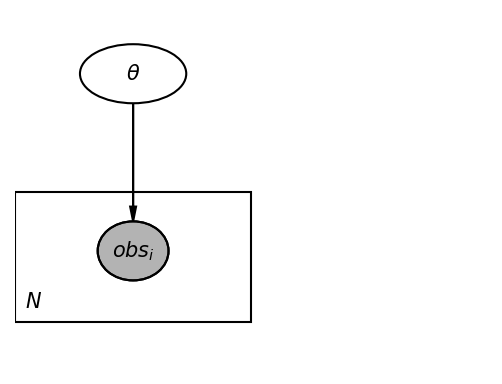

In [8]:
pgm = daft.PGM([4, 3], origin=[0, 0])
pgm.add_node(daft.Node("theta", r"$\theta$", 1, 2.5, aspect=1.8))

pgm.add_node(daft.Node("obs", r"$obs_i$", 1, 1, aspect=1.2, observed=True))

pgm.add_edge("theta", "obs")
pgm.add_plate([0, 0.5, 2, 1.0], label=r"$N$", shift=-0.1)
_ = pgm.render(dpi=150)

In [9]:
def neg_log_likelihood(theta, dataset):
    distribution_obj = dist.Bernoulli(probs=theta)
    return -distribution_obj.log_prob(dataset).sum()

We can find the likelihood for different thetas.

In [10]:
neg_log_likelihood(0.2, dataset_100), neg_log_likelihood(0.6, dataset_100)

(DeviceArray(127.67271, dtype=float32), DeviceArray(60.813713, dtype=float32))

We can also use `vmap` to compute the likelihood over a range of thetas.

In [11]:
# None for second argument as we don't need vmap for dataset
neg_log_likelihood_vmap = jax.vmap(neg_log_likelihood, in_axes=(0, None)) 

In [12]:
theta_array = jnp.linspace(0.01, 0.99, 100)
nll_array = neg_log_likelihood_vmap(theta_array, dataset_100)

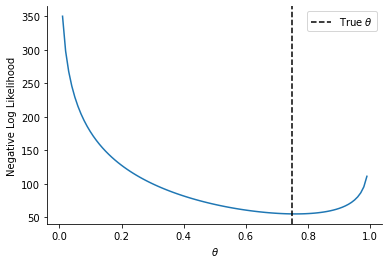

In [13]:
plt.plot(theta_array, nll_array)
sns.despine()
plt.axvline(0.75, linestyle='--', color='k', label=r'True $\theta$')
plt.legend()
plt.ylabel("Negative Log Likelihood")
_ = plt.xlabel(r"$\theta$")

### Learning MLE parameters via gradient descent

In [14]:
# We need gradient only respect to the first argument
grad_loss = jax.grad(neg_log_likelihood)

In [15]:
grad_loss(0.5, dataset_100)

DeviceArray(-104., dtype=float32, weak_type=True)

In [16]:
grad_loss(0.8, dataset_100)

DeviceArray(25.000008, dtype=float32, weak_type=True)

We can see that the gradient values starting with $\theta = 0.5$ will push towards increasing $\theta$ and vice versa starting with $\theta = 0.8$

In [17]:
optimizer = optax.sgd(learning_rate=0.001)

theta = jnp.array(0.1).round(2)

opt_state = optimizer.init(theta)

In [18]:
table = Table(title="MLE Convergence")

table.add_column("Iteration", justify="right", style="cyan", no_wrap=True)
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Theta", justify="right", style="green")


for i in range(10):
    cost_val = neg_log_likelihood(theta, dataset_100)
    table.add_row(str(i), f"{cost_val:0.2f}", f"{theta:0.2f}")
    grad_theta_val = grad_loss(theta, dataset_100)
    updates, opt_state = optimizer.update(grad_theta_val, opt_state)
    theta = optax.apply_updates(theta, updates)
print(table)

       MLE Convergence        
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Iteration ┃   Loss ┃ Theta ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│         0 │ 177.53 │  0.10 │
│         1 │  56.86 │  0.83 │
│         2 │  55.23 │  0.78 │
│         3 │  55.13 │  0.77 │
│         4 │  55.11 │  0.76 │
│         5 │  55.11 │  0.76 │
│         6 │  55.11 │  0.76 │
│         7 │  55.11 │  0.76 │
│         8 │  55.11 │  0.76 │
│         9 │  55.11 │  0.76 │
└───────────┴────────┴───────┘

### MAP

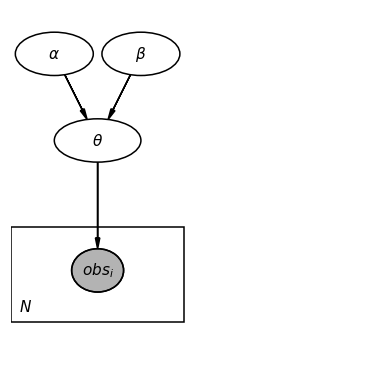

In [19]:
pgm = daft.PGM([4, 4], origin=[0, 0])
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 3.5, aspect=1.8))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 3.5, aspect=1.8))


pgm.add_node(daft.Node("theta", r"$\theta$", 1, 2.5, aspect=2))

pgm.add_node(daft.Node("obs", r"$obs_i$", 1, 1, aspect=1.2, observed=True))

pgm.add_edge("theta", "obs")
pgm.add_edge("alpha", "theta")
pgm.add_edge("beta", "theta")


pgm.add_plate([0, 0.5, 2, 1.0], label=r"$N$", shift=-0.1)
_ = pgm.render(dpi=110)

In [20]:
prior_alpha = 10.0
prior_beta = 10.0
prior_dist = dist.Beta(concentration1=prior_alpha, concentration0=prior_beta)

Our prior will give us samples on $\theta$. Let us draw a 100 samples and draw their histogram.

In [21]:
prior_samples = prior_dist.sample(sample_shape=(100), seed=key)

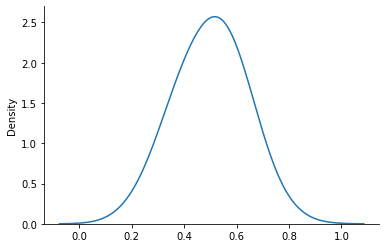

In [22]:
sns.kdeplot(prior_samples, bw_adjust=2)
sns.despine()

Now, given a $\theta$, we can evaluate the log prior and log likelihood and optimize their sum them to obtain the MAP estimate.

In [23]:
def neg_log_prior(theta, prior_dist):
    return -prior_dist.log_prob(theta)

In [24]:
neg_log_prior(0.1, prior_dist)

DeviceArray(7.9352818, dtype=float32)

In [25]:
neg_log_prior(0.5, prior_dist)

DeviceArray(-1.2595797, dtype=float32)

Clearly, we are much more likely to sample $\theta = 0.5$ from our prior in comparison to $\theta = 0.1$.

In [26]:
def joint_neg_log_prior_log_likelihood(theta, dataset, prior_dist):
    return neg_log_prior(theta, prior_dist) + neg_log_likelihood(theta, dataset)

In [27]:
grad_loss = jax.grad(joint_neg_log_prior_log_likelihood)
optimizer = optax.sgd(learning_rate=0.001)

theta = jnp.array(0.1).round(2)

opt_state = optimizer.init(theta)

In [28]:
table = Table(title="MAP Convergence")

table.add_column("Iteration", justify="right", style="cyan", no_wrap=True)
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Theta", justify="right", style="green")


for i in range(10):
    cost_val = joint_neg_log_prior_log_likelihood(theta, dataset_100, prior_dist)
    table.add_row(str(i), f"{cost_val:0.2f}", f"{theta:0.2f}")
    grad_theta_val = grad_loss(theta, dataset_100, prior_dist)
    updates, opt_state = optimizer.update(grad_theta_val, opt_state)
    theta = optax.apply_updates(theta, updates)
print(table)

       MAP Convergence        
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Iteration ┃   Loss ┃ Theta ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│         0 │ 185.46 │  0.10 │
│         1 │  74.68 │  0.91 │
│         2 │  58.55 │  0.63 │
│         3 │  56.80 │  0.67 │
│         4 │  56.33 │  0.70 │
│         5 │  56.22 │  0.71 │
│         6 │  56.20 │  0.72 │
│         7 │  56.20 │  0.72 │
│         8 │  56.19 │  0.72 │
│         9 │  56.19 │  0.72 │
└───────────┴────────┴───────┘

In [29]:
f"{(dataset_100.sum()+10)/(120):0.2f}"

'0.72'

### Analytical Posterior

$$P(\theta|Data) \sim Beta(\#Heads~in~Data + \alpha, \#Tails~in~Data + \beta)$$

In [30]:
analytical_posterior = dist.Beta(dataset_100.sum() + prior_alpha, 100.-dataset_100.sum() + prior_beta)

In [31]:
analytical_posterior.concentration1, analytical_posterior.concentration0

(DeviceArray(86., dtype=float32, weak_type=True),
 DeviceArray(34., dtype=float32, weak_type=True))

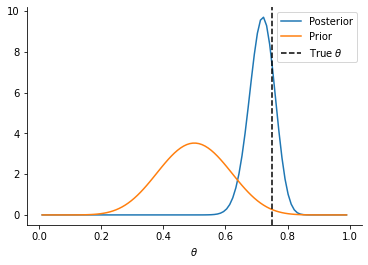

In [32]:
plt.plot(theta_array, analytical_posterior.prob(theta_array), label='Posterior')
plt.plot(theta_array, prior_dist.prob(theta_array), label='Prior')
plt.axvline(0.75, linestyle='--', color='k', label=r'True $\theta$')


sns.despine()
_ = plt.xlabel(r"$\theta$")
plt.legend()

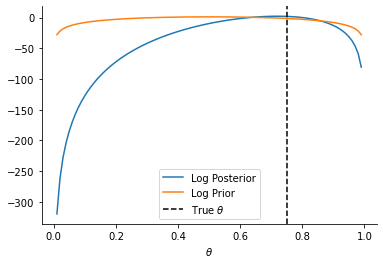

In [33]:
plt.plot(theta_array, analytical_posterior.log_prob(theta_array), label='Log Posterior')
plt.plot(theta_array, prior_dist.log_prob(theta_array), label='Log Prior')
plt.axvline(0.75, linestyle='--', color='k', label=r'True $\theta$')


sns.despine()
_ = plt.xlabel(r"$\theta$")
plt.legend()

### MCMC

Implementation of Metropolis algorithm from scratch

In [34]:
def next_sample(cur_sample, key):
    return dist.Normal(loc = cur_sample, scale=0.2).sample(seed=key, sample_shape=() )

In [35]:
key = jax.random.PRNGKey(5)
_, k = jax.random.split(key, 2)
next_sample(1.0, k)

DeviceArray(1.2128564, dtype=float32)

In [36]:
@jax.jit
def lp(theta):
    return -joint_neg_log_prior_log_likelihood(theta, dataset_100, prior_dist)

In [37]:
lp(0.1)

DeviceArray(-185.46045, dtype=float32)

In [41]:
x_start = 0.5
num_iter = 1000
xs = [x_start]
lu = jnp.log(dist.Uniform(0, 1).sample(sample_shape=[num_iter], seed=k))

keys = jax.random.split(k, num_iter)

for i in range(1, num_iter):
    ns = next_sample(xs[i-1], keys[i])
    if ns > 0.99:
        ns = 0.99
    if ns < 0.01:
        ns = 0.01
    xs.append(ns)
    la = lp(xs[i]) - lp(xs[i-1])

    if lu[i] > la:
        xs[i] = xs[i-1]

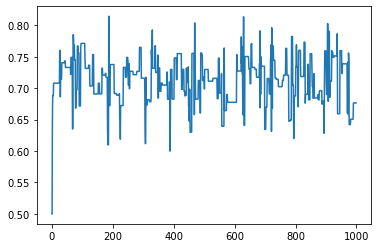

In [42]:
plt.plot(jnp.array(xs).reshape(-1, 1))

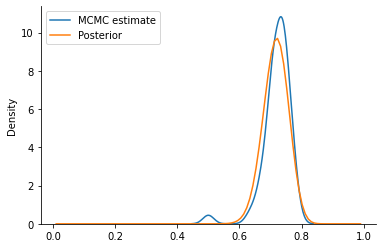

In [46]:
sns.kdeplot(jnp.array(xs), label='MCMC estimate')
plt.plot(theta_array, analytical_posterior.prob(theta_array), label='Posterior')
plt.legend()
sns.despine()

TODO

1. remove the warnings
2. check if can replace TFP with distrax here or pure jax.scipy.?
3. VI from scratch?
4. Document (and maybe create Class for MH sampling)
5. Better way for MCMC sampling when parameters are constrained? (like theta between 0 and 1?)
6. where other can we jit?
